In [1]:
import numpy as np
import pyldpc as ldpc
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import sys
from utils_f import load_code
import os
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
device='cuda:1'

In [3]:
H_filename = './source/BCH_15_11.alist'
code = load_code(H_filename)
H = code.H
G = code.G
var_degrees = code.var_degrees
chk_degrees = code.chk_degrees
num_edges = code.num_edges
u = code.u
d = code.d
n = code.n
m = code.m
k = code.k

In [56]:
class Decoder(torch.nn.Module):
    def __init__(self, num_iterations = 5):
        super(Decoder, self).__init__()
        # self.W_cv = torch.ones((num_iterations, num_edges))
        self.W_cv = torch.nn.Parameter(torch.abs(torch.ones((num_iterations, num_edges))))
        self.W_cv.requires_grad = True
        # self.B_cv = torch.zeros((num_iterations, num_edges))
        self.B_cv = torch.nn.Parameter(torch.abs(torch.zeros((num_iterations, num_edges))))
        self.B_cv.requires_grad = True
        # self.W_vc = torch.ones((num_iterations, num_edges))
        self.W_vc = torch.nn.Parameter(torch.abs(torch.ones((num_iterations, num_edges))))
        self.W_vc.requires_grad = True
        
        self.num_iterations = num_iterations
        
    def forward(self, soft_input):
        soft_input = soft_input.T           # TODO! Fix matrix dimensions inside functions
        # print(soft_input.shape)
        cv = torch.zeros((num_edges, soft_input.shape[1]))
        for iteration in range(0, self.num_iterations):
            vc = self.compute_vc(cv, soft_input, iteration)
            cv = self.compute_cv(vc, iteration)
            soft_input = self.marginalize(soft_input, cv)
        output = torch.sigmoid(-soft_input)
        output = output.T
        
        self.W_cv = torch.abs(self.W_cv)
        self.B_cv = torch.abs(self.B_cv)
        self.W_vc = torch.abs(self.W_vc)
        # output = soft_input
        return output

        
    def compute_vc(self, cv, soft_input, iteration):
        edges = []
        for i in range(0, n):
            for j in range(0, var_degrees[i]):
                edges.append(i)
        # print(soft_input.shape, len(edges), edges)
        reordered_soft_input = torch.index_select(soft_input, 0, torch.tensor(edges).to(device))

        vc = torch.zeros((num_edges, cv.shape[1])).to(device)
        counter = 0
        edge_order = []

        for i in range(0, n): # for each variable node v
            for j in range(0, var_degrees[i]):
                edge_order.append(d[i][j])
                extrinsic_edges = []
                for jj in range(0, var_degrees[i]):
                    if jj != j: # extrinsic information only
                        extrinsic_edges.append(d[i][jj])
                # if the list of edges is not empty, add them up
                if extrinsic_edges:
                    # print(cv.shape, len(extrinsic_edges), extrinsic_edges)
                    temp = torch.index_select(cv.to(device), 0, torch.tensor(extrinsic_edges).to(device))
                    temp = torch.sum(temp, 0)
                else:
                    temp = torch.zeros(cv.shape[1])

                temp = temp.to(device)
                vc[counter] = temp
        
        new_order = np.zeros(num_edges).astype(int)
        new_order[edge_order] = np.arange(0, num_edges)
        vc = torch.index_select(vc, 0, torch.tensor(new_order).to(device))
        vc += reordered_soft_input * torch.tile(torch.reshape(self.W_vc[iteration], (-1,1)), (1, cv.shape[1]))       # add soft inputs of the previous iterations!
        return vc 

    def compute_cv(self, vc, iteration):
        cv_list = []
        prod_list = []
        min_list = []
        edge_order = []
        for i in range(0, m): # for each check node c
            for j in range(0, chk_degrees[i]):
                edge_order.append(u[i][j])
                extrinsic_edges = []
                for jj in range(0, chk_degrees[i]):
                    if jj != j:
                        extrinsic_edges.append(u[i][jj])
                temp = torch.index_select(vc.to(device),0,torch.tensor(extrinsic_edges).to(device))
                temp1 = torch.prod(torch.sign(temp),0)
                temp2 = torch.min(torch.abs(temp),0)[0]
                prod_list.append(temp1)
                min_list.append(temp2)
        prods = torch.stack(prod_list)
        mins = torch.stack(min_list)
        mins = torch.relu(mins - torch.tile(torch.reshape(self.B_cv[iteration], (-1,1)), (1, vc.shape[1])))
        cv = prods * mins
        new_order = np.zeros(num_edges).astype(int)
        new_order[edge_order] = np.array(range(0,num_edges)).astype(int)
        cv = torch.index_select(cv, 0, torch.tensor(new_order).to(device))
        cv = cv * torch.tile(torch.reshape(self.W_cv[iteration], (-1,1)), (1, vc.shape[1]))
        return cv

    # combine messages to get posterior LLRs
    def marginalize(self, soft_input, cv):
        weighted_soft_input = soft_input
        soft_output = []
        for i in range(0,n):
            edges = []
            for e in range(0,var_degrees[i]):
                edges.append(d[i][e])
            temp = torch.index_select(cv,0,torch.tensor(edges).to(device))
            temp = torch.sum(temp, 0)
            soft_output.append(temp)
        soft_output = torch.stack(soft_output)
        soft_output = weighted_soft_input + soft_output
        return soft_output

In [57]:
def epoch_train(loader, clf, criterion, opt):
    clf.train(True)
    avg_loss = 0
    avg_acc = 0
    correct = 0
    # load batch
    for model_input, target in loader:
        # move data to device
        model_input = model_input.to(device)
        target = target.to(device)
        # calculate outputs, loss and accuracy
        model_output = clf(model_input)
        loss = criterion(model_output, target)
        # print(model_input[0], model_output[0])
        avg_loss += loss
        correct += torch.count_nonzero(torch.heaviside(model_output-0.5, torch.tensor([0.]).to(device)).to(device) == target)
        # calculate grad, upd weights
        opt.zero_grad()
        loss.backward()
        opt.step()
    avg_loss = avg_loss / len(loader)
    avg_acc = correct / len(loader.dataset)
    return avg_loss, avg_acc

            
            
                        
def epoch_test(loader, clf, criterion):
    clf.eval()
    avg_loss = 0
    avg_acc = 0
    correct = 0
    # load batch
    for model_input, target in loader:
        # move data to device
        model_input = model_input.to(device)
        target = target.to(device)
        # calculate outputs, loss and accuracy
        model_output = clf(model_input)
        loss = criterion(model_output, target)
        avg_loss += loss
        correct += torch.count_nonzero(torch.heaviside(model_output-0.5, torch.tensor([0.]).to(device)).to(device) == target)
    avg_loss = avg_loss / len(loader)
    avg_acc = correct / len(loader.dataset)

    return avg_loss, avg_acc

def train(train_loader, test_loader, clf, criterion, opt, n_epochs=50):
    for epoch in trange(n_epochs):
        train_loss, train_acc = epoch_train(train_loader, clf, criterion, opt)
        test_loss, test_acc = epoch_test(test_loader, clf, criterion)

        if (np.mod(epoch+1,1)==0):
            print(f'[Epoch {epoch + 1}] train loss: {train_loss:.3f}; train acc: {train_acc:.2f}; ' + 
                  f'test loss: {test_loss:.3f}; test acc: {test_acc:.2f}')

## Create dataloader

In [58]:
train_size = 100000

def gen():
    messages = np.random.randint(0,2,[train_size,k])
    codewords = messages @ G % 2
    BPSK_codewords = (0.5 - codewords.astype(np.float32)) * 2.0
    soft_input = np.zeros_like(BPSK_codewords)
    SNRs = np.arange(1,6)
    for i in range(0,len(SNRs)):
        sigma = np.sqrt(1. / (2 * (np.float(k)/np.float(n)) * 10**(SNRs[i]/10)))
        noise = sigma * np.random.randn(train_size//len(SNRs),n)
        start_idx = train_size*i//len(SNRs)
        end_idx = train_size*(i+1)//len(SNRs)
        soft_input[start_idx:end_idx,:] = BPSK_codewords[start_idx:end_idx,:] + noise
        soft_input = 2 * soft_input / (sigma**2)
    return soft_input, codewords
    
    
    
def update_loaders():


    soft_input_train, codewords_train = gen()
    train_X = torch.Tensor(soft_input_train) # transform to torch tensor
    train_y = torch.Tensor(codewords_train)
    training_dataset = torch.utils.data.TensorDataset(train_X, train_y) # create your datset
    training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=20000, shuffle=True) # create your dataloader


    soft_input_test, codewords_test = gen()
    test_X = torch.Tensor(soft_input_test) # transform to torch tensor
    test_y = torch.Tensor(codewords_test)
    test_dataset = torch.utils.data.TensorDataset(test_X, test_y) # create your datset
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=20000, shuffle=True) # create your dataloader
    return training_loader, test_loader

In [59]:
decoder = Decoder(num_iterations=5).to(device)
opt = torch.optim.Adam(decoder.parameters(), lr=0.01)
# opt = torch.optim.SGD(decoder.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
# criterion = torch.nn.MSELoss()

In [60]:
n_upd = 10

test_size = 100000
SNRs = np.arange(-10,10)
results_hard = torch.zeros(len(SNRs))
results_nn = torch.zeros(n_upd, len(SNRs))

for upd in range(n_upd):
    print(f'{upd+1}/5')
    training_loader, test_loader = update_loaders()
    train(training_loader, test_loader, decoder, criterion, opt, n_epochs=10)

    decoder.eval()
    messages = torch.randint(0, 2, (test_size, k))
    codewords = messages @ G % 2
    codewords = codewords.to(device)
    BPSK_codewords = (0.5 - codewords) * 2
    for i, snr in enumerate(SNRs):
        sigma = np.sqrt(1. / (2 * (np.float(k)/np.float(n)) * 10**(snr/10)))
        noise = torch.tensor(sigma).to(device) * torch.randn(test_size, n).to(device)
        soft_input = BPSK_codewords + noise
        correct_hard = torch.count_nonzero((-(torch.sign(soft_input) - 1)/2) == codewords)
        correct_nn = torch.count_nonzero(torch.heaviside(decoder(soft_input) - 0.5, torch.tensor([0.]).to(device)) == codewords)
        print(f'SNR: {snr}, correct: {correct_nn}, errors: {test_size*n - correct_nn}')
        results_hard[i] = correct_hard
        results_nn[upd][i] = correct_nn

1/5


  0%|                                                                                                                               | 0/10 [00:00<?, ?it/s]


TypeError: cannot assign 'torch.cuda.FloatTensor' as parameter 'W_cv' (torch.nn.Parameter or None expected)

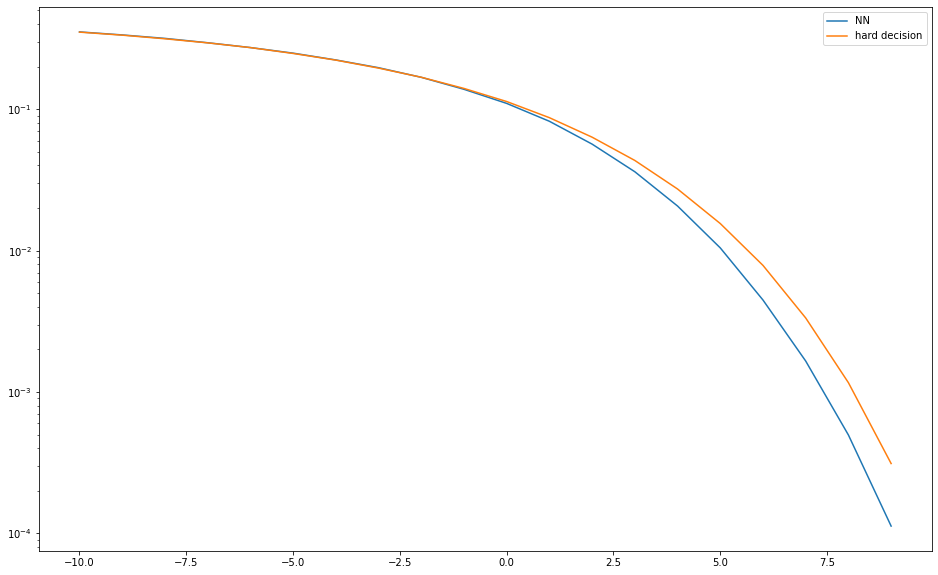

In [37]:
plt.figure(figsize=(16,10))
plt.semilogy(SNRs, (test_size*n - results_nn[0].numpy()) / (test_size*n), label='NN')
plt.semilogy(SNRs, (test_size*n - results_hard.numpy()) / (test_size*n), label='hard decision')
plt.legend()
plt.show()

In [ ]:
decoder(soft_input)[0] - 0.5

In [ ]:
codewords[0]

In [ ]:
decoder.W_vc